## Определение перспективного тарифа для телеком компании



### Описание тарифов:

#### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
  - минута разговора: 3 рубля
  - сообщение: 3 рубля
  - 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
  - минута разговора: 1 рубль
  - сообщение: 1 рубль
  - 1 Гб интернет-трафика: 150 рублей

### Шаг 1.  Изучим общую информацию и обработаем данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st


In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv') 
messages = pd.read_csv('/datasets/messages.csv') 
tariffs = pd.read_csv('/datasets/tariffs.csv') 
users = pd.read_csv('/datasets/users.csv') 

#### Рассмотрим таблицу звонков:

In [3]:
print(calls.head(10))

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
5  1000_5  2018-11-02      0.00     1000
6  1000_6  2018-10-18      0.00     1000
7  1000_7  2018-08-22     18.31     1000
8  1000_8  2018-09-15     18.44     1000
9  1000_9  2018-08-15      0.00     1000


In [4]:
len(calls)

202607

Проверим на наличие пропусков:

In [5]:
print(calls.isnull().sum())

id           0
call_date    0
duration     0
user_id      0
dtype: int64


Исходя из условия, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Округлим все значения столбца 'duration'. Применим функцию, которая округляет значение до минимальнго целого, большего нежели исходное значние.

In [6]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


Рассмотрим диаграмму значений длительности звонков:

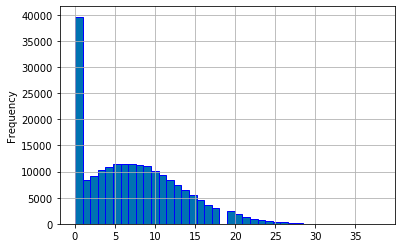

In [7]:
plt.style.use('seaborn-colorblind')
calls['duration'].plot(kind='hist', ec='blue', bins=40, grid=True)

На диаграмме видим большое количество нулевых значений, найдем их количество:

In [8]:
len(calls.query('duration == 0'))

39613

Нулевые значения возможно могут означать звонки, которые были произведены, но по каким-то причинам не состоялись, будь-то были сброшены, занято, недоступность абонента или подобные случаи, когда вызов был произведен, но по факту длительность разговора равно 0. Удалим такие строки, т.к. они никак не влияют на расход минут и лишь засоряют данные.

In [9]:
calls = calls.query('duration > 0')

In [10]:
len(calls)

162994

Проверим форматы данных:

In [11]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null object
duration     162994 non-null float64
user_id      162994 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Изменим формат данных на целочисленный для значений длительности звонков, т.к. они округленны и принимают только целые значения, т.к. для столбца 'call_date' изменим тип на формат даты

In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = calls['duration'].astype('int')

In [13]:
print(calls.head(10))

         id  call_date  duration  user_id
2    1000_2 2018-06-11         3     1000
3    1000_3 2018-09-21        14     1000
4    1000_4 2018-12-15         6     1000
7    1000_7 2018-08-22        19     1000
8    1000_8 2018-09-15        19     1000
10  1000_10 2018-08-22         6     1000
11  1000_11 2018-05-28        19     1000
12  1000_12 2018-07-05         3     1000
13  1000_13 2018-09-29         8     1000
14  1000_14 2018-12-11        10     1000


#### Рассмотрим таблицу, где указана информация об интернет-сессиях:

In [14]:
print(internet.head(10))

   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000
5           5  1000_5   399.97   2018-10-02     1000
6           6  1000_6   540.08   2018-09-07     1000
7           7  1000_7   415.70   2018-07-11     1000
8           8  1000_8   505.40   2018-10-08     1000
9           9  1000_9   345.54   2018-09-03     1000


In [15]:
len(internet)

149396

Проверим на наличие пропусков:

In [16]:
print(internet.isnull().sum())

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64


Исходя из услоывия, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Округлим все значения столбца 'duration'.

In [17]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113.0,2018-11-25,1000
1,1,1000_1,1053.0,2018-09-07,1000
2,2,1000_2,1198.0,2018-06-25,1000
3,3,1000_3,551.0,2018-08-22,1000
4,4,1000_4,303.0,2018-09-24,1000


Рассмотрим диаграмму значений объёма потраченного за сессию интернет-трафика (в мегабайтах):

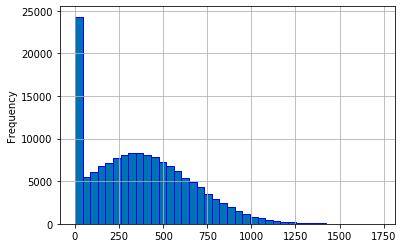

In [18]:
plt.style.use('seaborn-colorblind')
internet['mb_used'].plot(kind='hist', ec='blue', bins=40, grid=True)

На диаграмме видим большое количество нулевых значений, найдем их количество:

In [19]:
len(internet.query('mb_used == 0'))

19598

Нулевые значения могут обозначать факт подключения к интернету без дальнейшего его использования. Удалим такие строки, т.к. они никак не влияют на расход трафика и лишь засоряют данные.

In [20]:
internet = internet.query('mb_used > 0')

Проверим форматы данных:

In [21]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      129798 non-null int64
id              129798 non-null object
mb_used         129798 non-null float64
session_date    129798 non-null object
user_id         129798 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.9+ MB


Изменим формат данных на целочисленный для значений трафика, т.к. они округленны и принимают только целые значения,  для столбца 'session_date' изменим тип на формат даты

In [22]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['mb_used'] = internet['mb_used'].astype('int')

In [23]:
print(internet.head(10))

   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0      113   2018-11-25     1000
1           1  1000_1     1053   2018-09-07     1000
2           2  1000_2     1198   2018-06-25     1000
3           3  1000_3      551   2018-08-22     1000
4           4  1000_4      303   2018-09-24     1000
5           5  1000_5      400   2018-10-02     1000
6           6  1000_6      541   2018-09-07     1000
7           7  1000_7      416   2018-07-11     1000
8           8  1000_8      506   2018-10-08     1000
9           9  1000_9      346   2018-09-03     1000


#### Рассмотрим таблицу, где указана информация о сообщениях:

In [24]:
print(messages.head(10))

       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
5  1000_5   2018-06-20     1000
6  1000_6   2018-11-19     1000
7  1000_7   2018-10-29     1000
8  1000_8   2018-06-25     1000
9  1000_9   2018-12-18     1000


In [25]:
print(messages.isnull().sum())

id              0
message_date    0
user_id         0
dtype: int64


Проверим типы данных:

In [26]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Изменим тип данных 'message_date' на формат даты:

In [27]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

#### Рассмотрим таблицу, где указана информация о тарифах:

In [28]:
print(tariffs)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  


#### Рассмотрим таблицу, где указана информация о пользователях:

In [29]:
print(users.head(10))

   user_id  age churn_date              city first_name  last_name  \
0     1000   52        NaN         Краснодар     Рафаил  Верещагин   
1     1001   41        NaN            Москва       Иван       Ежов   
2     1002   59        NaN       Стерлитамак    Евгений  Абрамович   
3     1003   23        NaN            Москва      Белла   Белякова   
4     1004   68        NaN       Новокузнецк    Татьяна   Авдеенко   
5     1005   67        NaN  Набережные Челны   Афанасий     Горлов   
6     1006   21        NaN         Ульяновск     Леонид   Ермолаев   
7     1007   65        NaN            Москва        Юна   Березина   
8     1008   63        NaN         Челябинск     Рустэм  Пономарёв   
9     1009   24        NaN             Пермь   Василиса    Блинова   

     reg_date tariff  
0  2018-05-25  ultra  
1  2018-11-01  smart  
2  2018-06-17  smart  
3  2018-08-17  ultra  
4  2018-05-14  ultra  
5  2018-01-25  smart  
6  2018-02-26  smart  
7  2018-04-19  smart  
8  2018-12-19  smart  

In [30]:
len(users)

500

Проверим некоторые значения:

In [31]:
print(users['age'].max())
print(users['age'].min())

75
18


In [32]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

Изменим тип данных 'reg_date' и 'churn_date'  на формат даты:

In [33]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [34]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Посчитаем для каждого пользователя

#### Количество сделанных звонков и израсходованных минут разговора по месяцам:

In [35]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [36]:
calls_month = calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum'])
print(calls_month)

               count  sum
user_id month            
1000    5         17  159
        6         28  172
        7         41  340
        8         42  408
        9         46  466
...              ...  ...
1498    10        30  247
1499    9          8   70
        10        44  449
        11        62  612
        12        56  492

[3168 rows x 2 columns]


#### Количество отправленных сообщений по месяцам:

In [37]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [38]:
messages_month = messages.groupby(['user_id', 'month'])['id'].count()
print(messages_month)

user_id  month
1000     5        22
         6        60
         7        75
         8        81
         9        57
                  ..
1498     10       42
1499     9        11
         10       48
         11       59
         12       66
Name: id, Length: 2717, dtype: int64


#### Объем израсходованного интернет-трафика по месяцам:

In [39]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [40]:
internet_month = internet.groupby(['user_id', 'month'])['mb_used'].sum()
print(internet_month)

user_id  month
1000     5         2256
         6        23257
         7        14016
         8        14070
         9        14581
                  ...  
1498     10       20604
1499     9         1848
         10       17809
         11       17984
         12       13077
Name: mb_used, Length: 3201, dtype: int64


#### Помесячную выручку с каждого пользователя :

Соберем данные 3 таблиц в одну:

In [41]:
df_month = pd.concat([calls_month,messages_month,internet_month], axis=1)
df_month = df_month.reset_index()
df_month.head()

,user_id,month,count,sum,id,mb_used
0,1000,5,17.0,159.0,22.0,2256.0
1,1000,6,28.0,172.0,60.0,23257.0
2,1000,7,41.0,340.0,75.0,14016.0
3,1000,8,42.0,408.0,81.0,14070.0
4,1000,9,46.0,466.0,57.0,14581.0


Переименуем столбцы:

In [42]:
df_month.columns = ['user_id', 'месяц', 'звонки', 'длительность', 'сообщения', 'трафик_мб']

Проверим на наличие пропусков:

In [43]:
print(df_month.isnull().sum())

user_id           0
месяц             0
звонки           46
длительность     46
сообщения       497
трафик_мб        13
dtype: int64


Пропуски могли образоваться из-за того, что  некоторые из пользователей за рассматриваемый период времени или ни разу не звонили, или ни разу не отправляли СМС, или ни разу не выходили в интернет. Значит нужно заменить их на 0 значения.

In [44]:
df_month['звонки'] = df_month['звонки'].fillna(0)
df_month['длительность'] = df_month['длительность'].fillna(0)
df_month['сообщения'] = df_month['сообщения'].fillna(0)
df_month['трафик_мб'] = df_month['трафик_мб'].fillna(0)

Добавим в таблицу данные о тарифах, городе и абонентской плате:

In [45]:
tariff = dict(pd.Series(users['tariff'].values, index=users['user_id']))
df_month['тариф'] = df_month['user_id'].map(tariff)

city = dict(pd.Series(users['city'].values, index=users['user_id']))
df_month['город'] = df_month['user_id'].map(city)

In [46]:
def tarif(row):
    if row['тариф'] == 'ultra':
        return 1950
    else:
        return 550

In [47]:
df_month['аб_плата, руб.'] = df_month.apply(tarif, axis = 1)

In [48]:
print(df_month)

      user_id  месяц  звонки  длительность  сообщения  трафик_мб  тариф  \
0        1000      5    17.0         159.0       22.0     2256.0  ultra   
1        1000      6    28.0         172.0       60.0    23257.0  ultra   
2        1000      7    41.0         340.0       75.0    14016.0  ultra   
3        1000      8    42.0         408.0       81.0    14070.0  ultra   
4        1000      9    46.0         466.0       57.0    14581.0  ultra   
...       ...    ...     ...           ...        ...        ...    ...   
3209     1498     10    30.0         247.0       42.0    20604.0  smart   
3210     1499      9     8.0          70.0       11.0     1848.0  smart   
3211     1499     10    44.0         449.0       48.0    17809.0  smart   
3212     1499     11    62.0         612.0       59.0    17984.0  smart   
3213     1499     12    56.0         492.0       66.0    13077.0  smart   

            город  аб_плата, руб.  
0       Краснодар            1950  
1       Краснодар          

Функция для вычисления данных о переплатах сверх абонентской платы:

Для звонков:

In [49]:
def calls_over_plan(row):
    if row['тариф'] == 'smart':
        if  (row['длительность'] - 500) <= 0:
            return 0
        else: 
            (row['длительность'] - 500) > 0
            return (row['длительность'] - 500)*3
        
    else:
        if  (row['длительность'] - 3000) <= 0:
            return 0
        else: 
            (row['длительность'] - 3000) > 0
            return (row['длительность'] - 3000)
        

In [50]:
df_month['минуты_сверх'] = df_month.apply(calls_over_plan, axis=1)

Для сообщений:

In [51]:
def messagers_over_plan(row):
    if row['тариф'] == 'smart':
        if  (row['сообщения'] - 50) <= 0:
            return 0
        else: 
            (row['сообщения'] - 50) > 0
            return (row['сообщения'] - 50)*3
        
    else:
        if  (row['сообщения'] - 1000) <= 0:
            return 0
        else: 
            (row['сообщения'] - 1000) > 0
            return (row['сообщения'] - 1000)

In [52]:
df_month['сообщения_сверх'] = df_month.apply(messagers_over_plan, axis=1)

Добавим столбцев в котором будут отображаться данные о трафике в гб, а затем вычислим данные о переплатах сверх абонентской платы:

In [53]:
df_month['трафик_гб'] = df_month['трафик_мб'] / 1024
df_month['трафик_гб'] = df_month['трафик_гб'].apply(np.ceil)

In [54]:
def internet_over_plan(row):
    if row['тариф'] == 'smart':
        if  (row['трафик_гб'] - 15) <= 0:
            return 0
        else: 
            (row['трафик_гб'] - 15) > 0
            return (row['трафик_гб'] - 15)*200
        
    else:
        if  (row['трафик_гб'] - 30) <= 0:
            return 0
        else: 
            (row['трафик_гб'] - 30) > 0
            return (row['трафик_гб'] - 30)*150

In [55]:
df_month['трафик_сверх'] = df_month.apply(internet_over_plan, axis=1)

In [56]:
print(df_month)

      user_id  месяц  звонки  длительность  сообщения  трафик_мб  тариф  \
0        1000      5    17.0         159.0       22.0     2256.0  ultra   
1        1000      6    28.0         172.0       60.0    23257.0  ultra   
2        1000      7    41.0         340.0       75.0    14016.0  ultra   
3        1000      8    42.0         408.0       81.0    14070.0  ultra   
4        1000      9    46.0         466.0       57.0    14581.0  ultra   
...       ...    ...     ...           ...        ...        ...    ...   
3209     1498     10    30.0         247.0       42.0    20604.0  smart   
3210     1499      9     8.0          70.0       11.0     1848.0  smart   
3211     1499     10    44.0         449.0       48.0    17809.0  smart   
3212     1499     11    62.0         612.0       59.0    17984.0  smart   
3213     1499     12    56.0         492.0       66.0    13077.0  smart   

            город  аб_плата, руб.  минуты_сверх  сообщения_сверх  трафик_гб  \
0       Краснодар   

In [57]:
len(df_month)

3214

Найдем помесячную выручку с каждого пользователя:

In [58]:
df_month['выручка'] = df_month['минуты_сверх'] + df_month['сообщения_сверх'] + df_month['трафик_сверх'] + df_month['аб_плата, руб.']

Общая выручка по каждому тарифу:

In [59]:
df_month.pivot_table(index='тариф', values='выручка', aggfunc = 'sum')

,выручка
тариф,
smart,2885751.0
ultra,2040000.0


In [60]:
viruchka = df_month.groupby(['user_id', 'месяц'])['выручка'].sum()
print(viruchka.head(10))

user_id  месяц
1000     5        1950.0
         6        1950.0
         7        1950.0
         8        1950.0
         9        1950.0
         10       1950.0
         11       1950.0
         12       1950.0
1001     11       1350.0
         12        550.0
Name: выручка, dtype: float64


Посчитаем выручку с тарифов благодаря покупке дополнительных пакетов трафика:

In [61]:
df_month.pivot_table(index='тариф', values='трафик_сверх', aggfunc='sum')

,трафик_сверх
тариф,
smart,1342800.0
ultra,119250.0


Заметим, что практически половину выручки от тарифа СМАРТ оператор связи получил от покупки дополнительных пакетов.

### Проанализируем данные:
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построем гистограммы:

#### Тариф СМАРТ:

In [62]:
df_smart = df_month.query('тариф == "smart"')

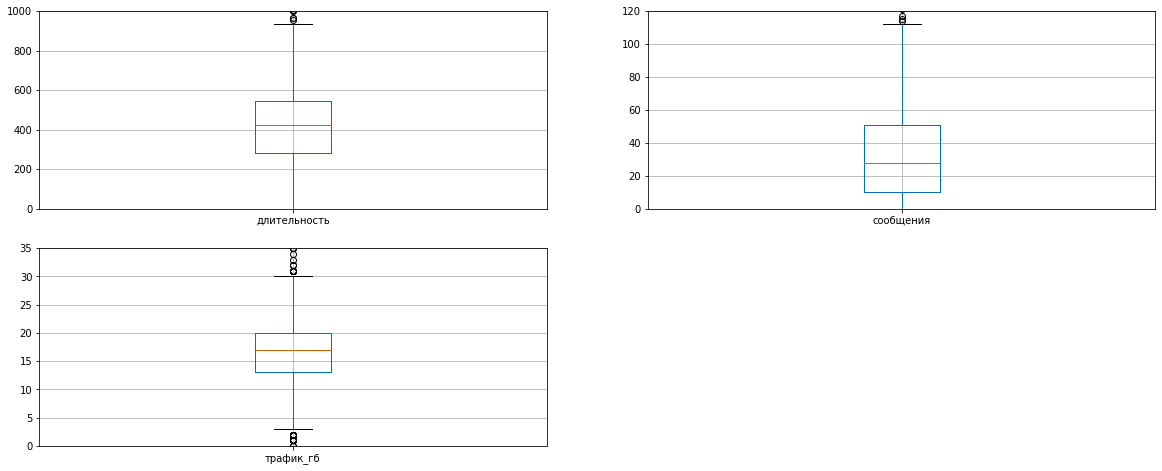

In [63]:
column_list1 = ['длительность', 'сообщения', 'трафик_гб']
ax = df_smart[column_list1].plot(kind='box', subplots=True, layout=(2,2), figsize=(20,8), grid=True)
ylims = [1000, 120, 35]
for i in range(len(column_list1)):
    ax[column_list1[i]].set_ylim(0, ylims[i])

In [64]:
column_list1 = ['длительность', 'сообщения', 'трафик_гб']
df_smart[column_list1].describe()

,длительность,сообщения,трафик_гб
count,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16.359354
std,190.313730,28.227876,5.758498
min,0.000000,0.000000,0.000000
25%,282.000000,10.000000,13.000000
50%,422.000000,28.000000,17.000000
75%,545.000000,51.000000,20.000000
max,1435.000000,143.000000,38.000000


In [65]:
def plot_hist_smart(data):
        
        mean = df_smart[data].mean
        print('Среднее значение:', mean())
        print()  
        std = df_smart[data].std()
        print('Стандартное отклонение:', std)
        print()
        variance = np.var(df_smart[data], ddof=1)
        print('Дисперсия:', variance)
        
        if data == 'длительность':
            df_smart[data].plot(kind='hist', ec='blue', bins=50, grid=True, title = 'Гистограмма длительности звонков')
            
        if data == 'сообщения':
            df_smart[data].plot(kind='hist', ec='blue', bins=50, grid=True, title = 'Гистограмма количества сообщений')
            
        if data == 'трафик_гб': 
            df_smart[data].plot(kind='hist', ec='blue', bins=50, grid=True, title = 'Гистограмма используемого трафика в ГБ')

Среднее значение: 417.9349484073576

Стандартное отклонение: 190.31372988921288

Дисперсия: 36219.31578434428


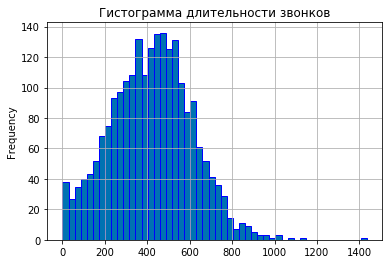

In [66]:
plot_hist_smart('длительность')

Среднее значение: 33.384028712427096

Стандартное отклонение: 28.22787555676141

Дисперсия: 796.8129584480083


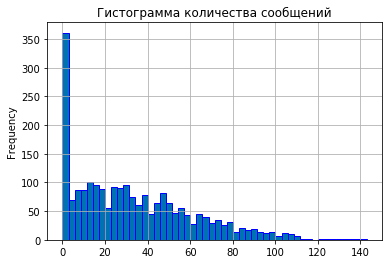

In [67]:
plot_hist_smart('сообщения')

Среднее значение: 16.35935397039031

Стандартное отклонение: 5.7584984215321935

Дисперсия: 33.16030407078876


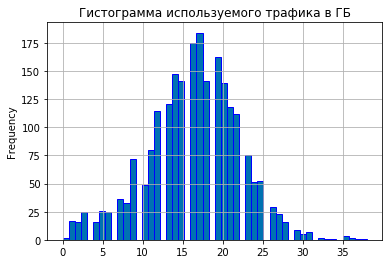

In [68]:
plot_hist_smart('трафик_гб')

#### Вывод для тарифа СМАРТ:

##### Длительность разговора:
В основном время разговора в данном тарифе лежит в диапазоне 282 - 445 минут, данные тариф хорошо подобран для людей, они вполне укладываются в необходимый лимит.
##### Количество сообщений:
Видно резкий всплеск нулевых значений, это значит, что пользователи просто не отправляют сообщения, что не мудрено в век социальных сетей и различных мессенжеров, СМС-ки нынче не пользуются спросом. А те, кто отправляет, в основномм отправляют от 10 до 50 СМС в месяц.
##### Трафик ГБ:
Основной диапазон трафика, который израсходовали пользователи лежим в пределах 13-20 ГБ в месяц, то есть можем сделать вывод, что людям не хватает трафика и им приходится приобретать дополнительные пакеты, чтобы дальше пользоваться интернетом. Заметим, что практически половину выручки от тарифа СМАРТ оператор связи получил от покупки пользователями дополнительных пакетов.

#### Тариф УЛЬТРА:

In [69]:
df_ultra = df_month.query('тариф == "ultra"')

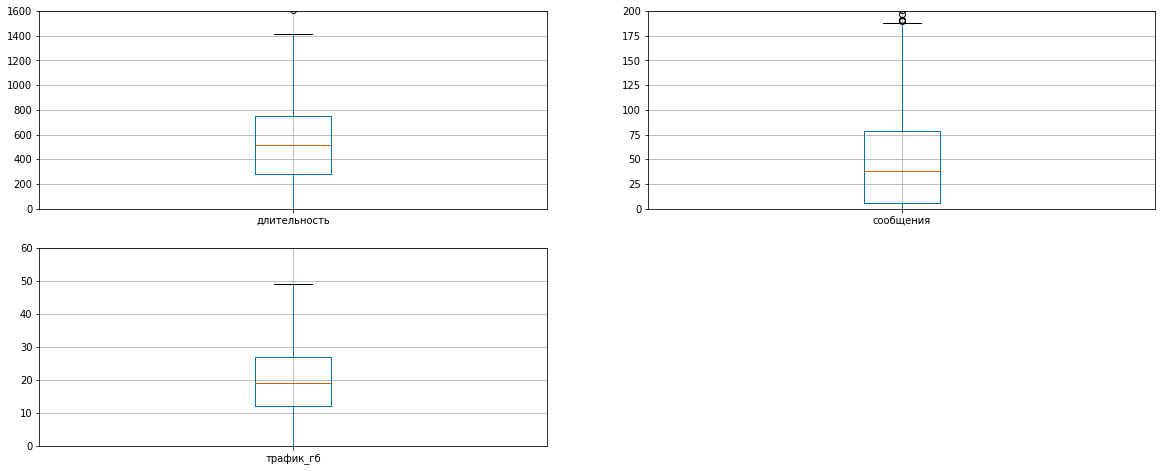

In [70]:
column_list1 = ['длительность', 'сообщения', 'трафик_гб']
ax = df_ultra[column_list1].plot(kind='box', subplots=True, layout=(2,2), figsize=(20,8), grid=True)
ylims = [1600, 200, 60]
for i in range(len(column_list1)):
    ax[column_list1[i]].set_ylim(0, ylims[i])

In [71]:
column_list1 = ['длительность', 'сообщения', 'трафик_гб']
df_ultra[column_list1].describe()

,длительность,сообщения,трафик_гб
count,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19.525888
std,317.606098,47.804457,9.865848
min,0.000000,0.000000,0.000000
25%,284.000000,6.000000,12.000000
50%,518.000000,38.000000,19.000000
75%,752.000000,79.000000,27.000000
max,1673.000000,224.000000,49.000000


In [72]:
def plot_hist_ultra(data):
        
        mean = df_ultra[data].mean
        print('Среднее значение:', mean())
        print()  
        std = df_ultra[data].std()
        print('Стандартное отклонение:', std)
        print()
        variance = np.var(df_ultra[data], ddof=1)
        print('Дисперсия:', variance)
        
        if data == 'длительность':
            df_ultra[data].plot(kind='hist', ec='blue', bins=50, grid=True, title = 'Гистограмма длительности звонков')
            
        if data == 'сообщения':
            df_ultra[data].plot(kind='hist', ec='blue', bins=50, grid=True, title = 'Гистограмма количества сообщений')
            
        if data == 'трафик_гб': 
            df_ultra[data].plot(kind='hist', ec='blue', bins=50, grid=True, title = 'Гистограмма используемого трафика в ГБ')
            
            


Среднее значение: 526.6233502538071

Стандартное отклонение: 317.6060978591264

Дисперсия: 100873.63339730098


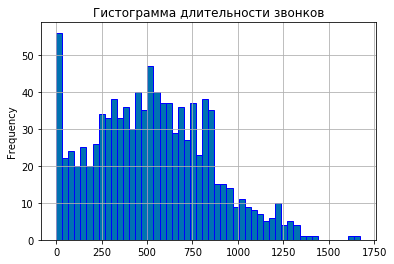

In [73]:
plot_hist_ultra('длительность')

Среднее значение: 49.36345177664975

Стандартное отклонение: 47.80445735017472

Дисперсия: 2285.266142544674


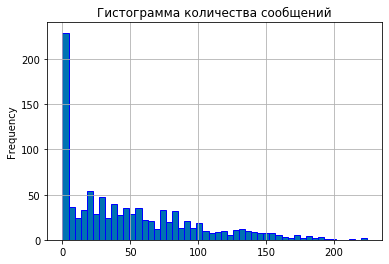

In [74]:
plot_hist_ultra('сообщения')

Среднее значение: 19.525888324873097

Стандартное отклонение: 9.865847608403014

Дисперсия: 97.33494903223145


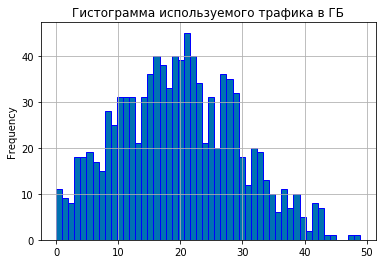

In [75]:
plot_hist_ultra('трафик_гб')

#### Вывод для тарифа УЛЬТРА:
##### Длительность разговора:
Данный тариф, по-моему мнению, точно берут не из-за минут на звонки, т.к. имеется большое количество пользователей, которые вообще не звонят, их потраченные минуты равны 0, а те кто всеже решились позвонить их время разговора лежит в диапазоне 284 - 752 минут , т.е. они не тратят даже 1/4 от общего количества минут, а их напомню 3000.
##### Количество сообщений:
С сообщениями дела обстоят также, как и в СМАРТЕ. Видно резкий всплеск нулевых значений, это значит, что пользователи просто не отправляют сообщения, а те, кто отправляет, в основном отправляют от 7 до 79 СМС в месяц.
##### Трафик ГБ:
Основной диапазон трафика, который израсходовали пользователи лежит в пределах 12-29 ГБ в месяц, то есть можем сделать вывод, что людям хватает заложенного в тарифе лимита, исходя из всех данных, мне кажется этот тариф берут как раз из-за увеличенного количества интернет-трафика, а минуты и сообщения, как хорошее дополнение.



### Правильность выбора тарифа

Посчитаем, сколько людей выбрали тариф правильно, учитывая параметры (звонки, сообщения, трафик).  Сделаем небольшую ракировку. Тем, кто пользуется СМАРТом присвоим тариф УЛЬТРА и наоборот, и посчитаем, какой тариф был бы выгоднее для пользователя. Для этого посчитаем выручку новую при смене тарифа на противоположный. Если старая выручка будет больше, нежели новая, значит при смене тарифа, пользователь мог сэкономить , обратное вычислять не будет, т.к. если выручка старая меньше новой, значит выбран был правильный тариф и мобильный оператор меньше поимел с абонента:

Вычислим новые переплаты за звонки, сообщения и трафик:

In [76]:
df_month['тариф_new'] = df_month['тариф']

In [77]:
def change_tarrif(row):
    new_tarrif = row['тариф_new']
    if 'smart' in new_tarrif:
        return 'ultra'
    if 'ultra' in new_tarrif:
        return 'smart'
        

In [78]:
df_month['тариф_new'] = df_month.apply(change_tarrif, axis = 1)

In [79]:
def calls_over_plan(row):
    if row['тариф_new'] == 'smart':
        if  (row['длительность'] - 500) <= 0:
            return 0
        else: 
            (row['длительность'] - 500) > 0
            return (row['длительность'] - 500)*3
        
    else:
        if  (row['длительность'] - 3000) <= 0:
            return 0
        else: 
            (row['длительность'] - 3000) > 0
            return (row['длительность'] - 3000)

In [80]:
df_month['минуты_сверх_new'] = df_month.apply(calls_over_plan, axis=1)

In [81]:
def messagers_over_plan(row):
    if row['тариф_new'] == 'smart':
        if  (row['сообщения'] - 50) <= 0:
            return 0
        else: 
            (row['сообщения'] - 50) > 0
            return (row['сообщения'] - 50)*3
        
    else:
        if  (row['сообщения'] - 1000) <= 0:
            return 0
        else: 
            (row['сообщения'] - 1000) > 0
            return (row['сообщения'] - 1000)

In [82]:
df_month['сообщения_сверх_new'] = df_month.apply(messagers_over_plan, axis=1)

In [83]:
def internet_over_plan(row):
    if row['тариф_new'] == 'smart':
        if  (row['трафик_гб'] - 15) <= 0:
            return 0
        else: 
            (row['трафик_гб'] - 15) > 0
            return (row['трафик_гб'] - 15)*200
        
    else:
        if  (row['трафик_гб'] - 30) <= 0:
            return 0
        else: 
            (row['трафик_гб'] - 30) > 0
            return (row['трафик_гб'] - 30)*150

In [84]:
df_month['трафик_сверх_new'] = df_month.apply(internet_over_plan, axis=1)

In [85]:
def tarif_new(row):
    if row['тариф_new'] == 'ultra':
        return 1950
    else:
        return 550

In [86]:
df_month['аб_плата_new, руб.'] = df_month.apply(tarif_new, axis = 1)

Найдем новое значение выручки:

In [87]:
df_month['выручка_new'] = df_month['минуты_сверх_new'] + df_month['сообщения_сверх_new'] + df_month['трафик_сверх_new'] + df_month['аб_плата_new, руб.']

In [88]:
viruchka_new = df_month.groupby(['user_id'])['выручка','выручка_new'].sum()



In [89]:
print(len(viruchka_new.query('выручка > выручка_new')))

112


In [90]:
viruchka_new = viruchka_new.query('выручка > выручка_new')

In [91]:
viruchka_new['разница'] = viruchka_new['выручка'] - viruchka_new['выручка_new']

In [92]:
viruchka_new['разница'].sum()

448378.0

#### В итоге мы получаем, 112 человек выбрали не тот тариф. И благодаря свой не гибкости помогли заработать компании 448 тыс. рублей, что составляет не много, ни мало 10% от общей выручки

### Проверяем гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

*H0 (нулевая гипотеза)* - предположение о том, что между данными нет связи. Средняя выручка пользователей тарифа Смарт не отличается от средней выручки пользователей тарифа Ультра.

*H1 (альтернативная гипотеза)* - средняя выручка пользователей тарифа Смарт отличается от средней выручки пользователей тарифа Ультра.



In [93]:
viruchka = df_month.groupby(['user_id', 'месяц'])['выручка'].sum()
print(viruchka.head(10))

user_id  месяц
1000     5        1950.0
         6        1950.0
         7        1950.0
         8        1950.0
         9        1950.0
         10       1950.0
         11       1950.0
         12       1950.0
1001     11       1350.0
         12        550.0
Name: выручка, dtype: float64


In [94]:
df_month_smart = df_month.query('тариф == "smart"')


In [95]:
smart_month_mean = df_month[(df_month['тариф'] == 'smart')]['выручка']

In [96]:
ultra_month_mean = df_month[(df_month['тариф'] == 'ultra')]['выручка']

In [97]:
smart_month_mean.mean()

1294.6393001345896

In [98]:
ultra_month_mean.mean()

2071.0659898477156

In [99]:
alpha = .05
results = st.ttest_ind(
    smart_month_mean, 
    ultra_month_mean)

In [100]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


#### Вывод:

Нулевую гипотезу отвергаем. По итогу получаем, что все же пользователи тарифа УЛЬТРА в среднем приносят больше, чем СМАРТа, это не странно, т.к. абонентская плата существенно отличается и покупки дополнительных звонков, сообщений и трафика сверх лимита, не перекрывают эту разницу


*H0 (нулевая гипотеза)* - предположение о том, что между данными нет связи. Средняя выручка пользователей города Москва не отличается от средней выручки пользователей других городов.

*H1 (альтернативная гипотеза)* - средняя выручка пользователей города Москва отличается от средней выручки пользователей других городов.


In [107]:
msc_month_mean = df_month[(df_month['город'] == 'Москва')]['выручка']
msc_month_mean

8       1350.0
9        550.0
17      1950.0
18      1950.0
19      1950.0
         ...  
3158     950.0
3159     550.0
3160    1750.0
3161    1350.0
3162     750.0
Name: выручка, Length: 611, dtype: float64

In [102]:
other_month_mean = df_month[(df_month['город'] != 'Москва')]['выручка']

In [103]:
alpha = .05
results = st.ttest_ind(
    msc_month_mean, 
    other_month_mean)

In [104]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


In [105]:
msc_month_mean.mean()

1550.8052373158755

In [106]:
other_month_mean.mean()

1528.3169419900116

Нулевую гипотезу не отвергаем. По итогу получаем, что все же пользователи города Москва в среднем приносят также, как и пользователи других городов. Разница среднего месячного значения выручки для Москвы, не существенно различается с показателями других городов.

## Общий вывод:

В данном проекте мы проанализировали два тарифных плана: «Смарт» и «Ультра». Причем при первом взгляде на стоимость данных тарифов, которая составляет 550 и 1950 рублей в месяц, кажется что Ультра должен приносить намного больше прибыли нежели Смарт, но посмотрев на то количество услуг сверх тарифного пакета, которое прибретают смартовцы , начинают закрадываться сомнения, например если посмотреть только на количество докупаемого трафика:

In [107]:
df_month.pivot_table(index='тариф', values='трафик_сверх', aggfunc='sum')


,трафик_сверх
тариф,
smart,1342800.0
ultra,119250.0


Только 1,3 млн было потрачено на интернет. Если сравнивать общую выручку, то Ультра принес за год больше, чем Смарт:

In [108]:
df_month.pivot_table(index='тариф', values='выручка', aggfunc = 'sum')

,выручка
тариф,
smart,2885751.0
ultra,2040000.0


На мой взгляд, компании Мегалайн нужно, как-то перераспределить лимиты звонков, сообщений и трафика, с учетом того, что, если раньше телефон нужен был для звонков и смсок, а интернет был некой второстепенной функцией, то сейчас все теже звонки и смс производимые через мобильную сеть, замещаются различными мессенжарами, что нужно учитывать при составлении лимитов на услуги. Современные люди проводят очень много времени на просторах интернета, за просмотром видео, соцсетей, читая какие-то статьи, сейчас грубо говоря, большинство развлечений и проведения досуга, как бы печально не звучало, но уходят все глубже в виртуальный мир и эти все аспекты нужно учитывать. Компании нужно обратить внимание так же, что если все начнут граммотно рассчитывать свои потребности в количестве звонков, сообщений и трафика, то компания бует терять прибыль. И нужно подбирать оптимальный новый тарифный план, чтобы и компании была хорошая прибыль и пользователям удобные лимиты.